In [1]:
from statsbombpy import sb
import pandas as pd

In [2]:
matches = sb.matches(competition_id=11, season_id=90)
barca_home_matches = matches[matches["home_team"]=="Barcelona"]
match_ids = barca_home_matches['match_id'].values.tolist()

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [3]:
events = sb.competition_events(
    country="Spain",
    division= "La Liga",
    season="2020/2021",
    gender="male"
)
events = events[events['match_id'].isin(match_ids)]
df = events[events["possession_team"]=="Barcelona"]

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [ ]:
df

In [306]:
events_passes = df[df['pass_recipient_id'].notnull()]
events_passes_filtered = events_passes[["location","pass_end_location","pass_goal_assist"]]

In [307]:
events_passes_filtered["start_x"] = events_passes_filtered["location"].str[0]
events_passes_filtered["start_y"] = events_passes_filtered["location"].str[1]
events_passes_filtered["end_x"] = events_passes_filtered["pass_end_location"].str[0]
events_passes_filtered["end_y"] = events_passes_filtered["pass_end_location"].str[1]


C:\Users\thors\AppData\Local\Temp\ipykernel_14096\275121082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered["start_x"] = events_passes_filtered["location"].str[0]
C:\Users\thors\AppData\Local\Temp\ipykernel_14096\275121082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered["start_y"] = events_passes_filtered["location"].str[1]
C:\Users\thors\AppData\Local\Temp\ipykernel_14096\275121082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [308]:
events_passes_filtered['start_node_x'] = round(events_passes_filtered['start_x'] / 20)
events_passes_filtered['start_node_y'] = round(events_passes_filtered['start_y'] / 20)
events_passes_filtered['end_node_x'] = round(events_passes_filtered['end_x'] / 20)
events_passes_filtered['end_node_y'] = round(events_passes_filtered['end_y'] / 20)

C:\Users\thors\AppData\Local\Temp\ipykernel_14096\2238505626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered['start_node_x'] = round(events_passes_filtered['start_x'] / 20)
C:\Users\thors\AppData\Local\Temp\ipykernel_14096\2238505626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered['start_node_y'] = round(events_passes_filtered['start_y'] / 20)
C:\Users\thors\AppData\Local\Temp\ipykernel_14096\2238505626.py:3: SettingWithCopyWarning: 
A value is trying to

In [309]:
events_passes_filtered

,location,pass_end_location,pass_goal_assist,start_x,start_y,end_x,end_y,start_node_x,start_node_y,end_node_x,end_node_y
2481,"[60.0, 40.0]","[49.4, 37.6]",NaN,60.0,40.0,49.4,37.6,3.0,2.0,2.0,2.0
2482,"[52.1, 37.6]","[49.4, 57.4]",NaN,52.1,37.6,49.4,57.4,3.0,2.0,2.0,3.0
2483,"[49.4, 57.4]","[35.0, 62.5]",NaN,49.4,57.4,35.0,62.5,2.0,3.0,2.0,3.0
2484,"[35.2, 62.3]","[7.3, 40.3]",NaN,35.2,62.3,7.3,40.3,2.0,3.0,0.0,2.0
2485,"[8.7, 36.8]","[21.4, 15.1]",NaN,8.7,36.8,21.4,15.1,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
40531,"[65.2, 43.9]","[82.9, 47.4]",NaN,65.2,43.9,82.9,47.4,3.0,2.0,4.0,2.0
40536,"[70.8, 0.1]","[77.7, 12.2]",NaN,70.8,0.1,77.7,12.2,4.0,0.0,4.0,1.0
40537,"[76.9, 12.3]","[63.6, 26.3]",NaN,76.9,12.3,63.6,26.3,4.0,1.0,3.0,1.0
40538,"[63.1, 28.5]","[65.2, 54.6]",NaN,63.1,28.5,65.2,54.6,3.0,1.0,3.0,3.0


In [310]:
events_passes_filtered["start_node"] = events_passes_filtered["start_node_x"] + events_passes_filtered["start_node_y"] / 10
events_passes_filtered["end_node"] = events_passes_filtered["end_node_x"] + events_passes_filtered["end_node_y"] / 10
events_passes_filtered = events_passes_filtered.drop(['start_x', 'start_y',"end_x","end_y",'location', 'pass_end_location',"start_node_x","start_node_y","end_node_y","end_node_x"], axis=1)

C:\Users\thors\AppData\Local\Temp\ipykernel_14096\156925537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered["start_node"] = events_passes_filtered["start_node_x"] + events_passes_filtered["start_node_y"] / 10
C:\Users\thors\AppData\Local\Temp\ipykernel_14096\156925537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_passes_filtered["end_node"] = events_passes_filtered["end_node_x"] + events_passes_filtered["end_node_y"] / 10


In [311]:
#remove edges between the same node
events_passes_filtered = events_passes_filtered[events_passes_filtered['start_node'] != events_passes_filtered['end_node']]

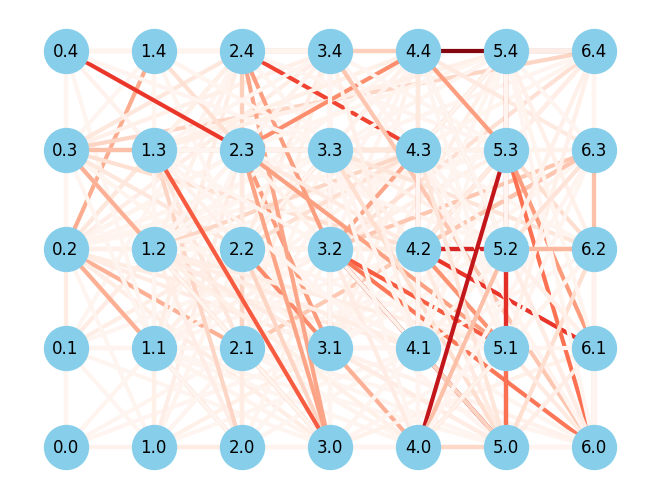

In [314]:
import matplotlib.pyplot as plt
import networkx as nx
events_passes_filtered['count'] = 1  
edge_counts = events_passes_filtered.groupby(['start_node', 'end_node'], as_index=False).count()
edge_counts = edge_counts[["start_node","end_node","count"]]
G=nx.from_pandas_edgelist(edge_counts, 'start_node', 'end_node', create_using=nx.Graph())


norm = plt.Normalize(vmin=edge_counts['count'].min(), vmax=edge_counts['count'].max())
edge_colors = plt.cm.Reds(norm(edge_counts['count']))

pos = {node: (node // 1, node % 1) for node in G.nodes()}

nx.draw(G,pos= pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color=edge_colors, width=3)

In [313]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df has two columns: 'start_node' and 'end_node', and frequency as 'count'
# Example dataframe creation for reference:
# df = pd.DataFrame({'start_node': ['1.2', '2.3', '3.4'], 'end_node': ['2.3', '3.4', '4.5'], 'count': [3, 2, 5]})

df['count'] = df['count'].fillna(1)  # Make sure there's a count column for edge weights

# Create a graph from the edge list in the dataframe
G = nx.from_pandas_edgelist(df, 'start_node', 'end_node', ['count'], create_using=nx.Graph())

# Normalize the edge weights (for color scaling)
norm = plt.Normalize(vmin=df['count'].min(), vmax=df['count'].max())
edge_colors = plt.cm.hot(norm(df['count']))

# Generate a position layout for your nodes (you can adjust this to your needs)
pos = {node: (float(node.split('.')[1]), float(node.split('.')[0])) for node in G.nodes()}

# Draw the graph with edges colored by their weights
nx.draw(G, pos=pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color=edge_colors, width=4)
plt.show()


KeyError: 'count'

ValueError: Invalid RGBA argument: 1

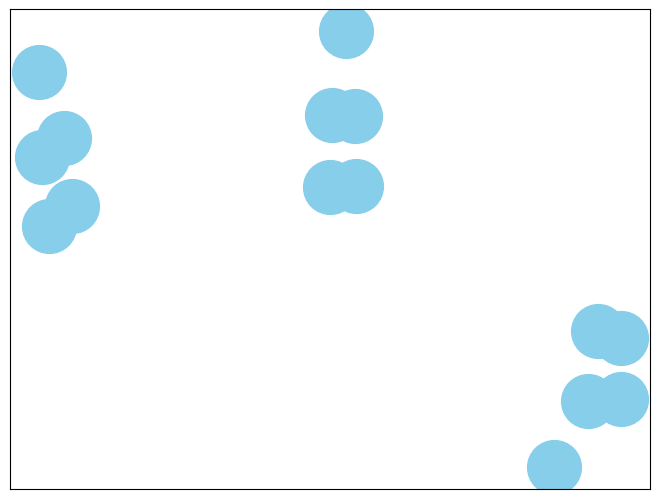

In [187]:
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color=df['count'], width=10.0, edge_cmap=plt.cm.Blues)

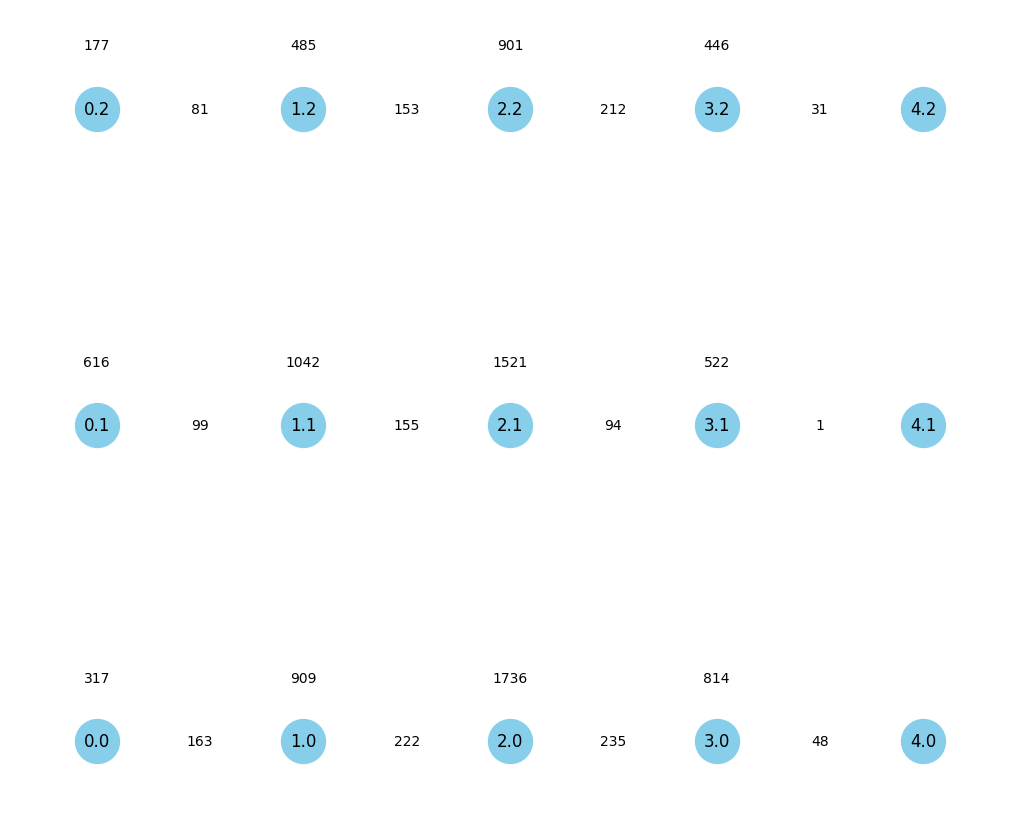

In [145]:
import matplotlib.pyplot as plt
import networkx as nx

# Set up the figure with a white background
plt.figure(figsize=(10, 8), facecolor='white')

# Define node positions
pos = {node: (int(node), node - int(node)) for node in G.nodes()}

# Get edge weights and ensure they are at least a small value for visibility
edges = G.edges(data=True)
weights = [max(edge[2]['count'], 0.5) for edge in edges]  # Minimum width 0.5

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", width=weights*100, edge_color='white')

# Draw edge labels (weights) on the graph
edge_labels = {(u, v): f"{d['count']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the plot
plt.show()
